# Regresión: Encuentra la edad!

Basado en una foto, adivina la edad de la persona.

In [3]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

from pathlib import Path
import random

## Los datos

En este caso usaremos el dataset de "UTK". En su tarea usarán otro dataset más bonito: después explico por qué!

## Analizando los datos

Después de descargarlos, vamos a verlos:

In [4]:
path = Path("utk/")

In [5]:
files = path.ls(); files

(#23708) [Path('utk/62_1_1_20170113013045520.jpg.chip.jpg'),Path('utk/28_0_1_20170114032935025.jpg.chip.jpg'),Path('utk/52_0_3_20170119205712208.jpg.chip.jpg'),Path('utk/63_0_3_20170119211951488.jpg.chip.jpg'),Path('utk/50_0_0_20170117172141491.jpg.chip.jpg'),Path('utk/50_0_0_20170120134101471.jpg.chip.jpg'),Path('utk/27_0_2_20170116174628743.jpg.chip.jpg'),Path('utk/46_1_0_20170110143242639.jpg.chip.jpg'),Path('utk/3_1_2_20161219155533269.jpg.chip.jpg'),Path('utk/30_1_0_20170117154138315.jpg.chip.jpg')...]

Pues resulta que el primer número del nombre del archivo denota la edad (estimada) de la persona.

In [6]:
def obtener_edad(archivo):
    return float(archivo.name.split("_")[0])

25_1_2_20170116175222886.jpg.chip.jpg --> 25.0


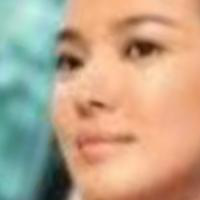

In [15]:
f = random.choice(files)
print(f"{f.name} --> {obtener_edad(f)}")
fv.PILImage.create(f)

In [16]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert=False, 
                             max_rotate=10, 
                             max_lighting=0.25, 
                             max_zoom=1.1, 
                             max_warp=0.1)
    
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.RegressionBlock),
                        get_items = fv.get_image_files,
                        get_y     = obtener_edad,
                        splitter  = fv.RandomSplitter(1/20),
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms= tfms,
                       )
    return data.dataloaders(folder, bs=batch_size)

In [17]:
data = load_data(path, img_size=192, batch_size=128)

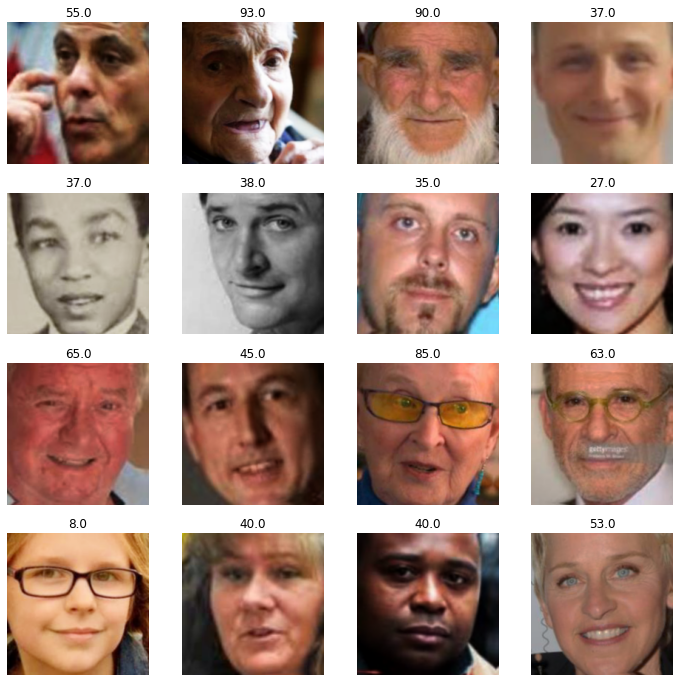

In [18]:
data.show_batch(max_n=16)

In [30]:
def flattened_l1(yp,y):
    return F.l1_loss(yp.squeeze(), y.squeeze())

In [34]:
learn = fv.vision_learner(data,
                          fv.resnet18,
                          loss_func = flattened_l1,
                          opt_func=fv.ranger,
                          normalize=False)

In [35]:
learn.fit_one_cycle(4,1e-2,pct_start=0.6,div=1)

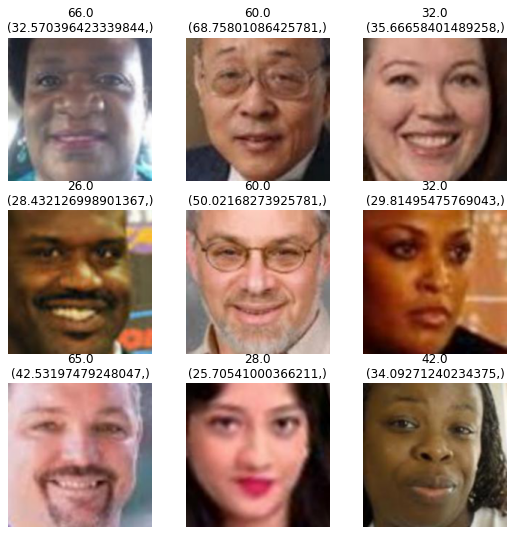

In [36]:
learn.show_results()

In [37]:
def resnet_split(m): 
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [38]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean= torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [39]:
list(fv.models.resnet18(pretrained=True).children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [40]:
fv.create_body??

Signature: fv.create_body(model, n_in=3, pretrained=True, cut=None)
Source:   
def create_body(model, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    return cut_model(model, cut)
File:      ~/anaconda3/envs/fastai/lib/python3.9/site-packages/fastai/vision/learner.py
Type:      function


In [57]:
fv.create_head(512,1,ps=0.4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=False)
)

In [58]:
class FullFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #return x.squeeze()
        return x.reshape(-1)

In [63]:
def create_learner(**kwargs):
    layers = [Normalizer()]
    layers += list(fv.models.resnet18(pretrained=True).children())[:-2]
    head = fv.create_head(512,1,ps=0.4)
    head[5] = nn.LeakyReLU()
    layers += list(head)
    layers += [FullFlatten()]
    model = nn.Sequential(*layers)
    learn = fv.Learner(data, model, opt_func=fv.ranger, splitter = resnet_split, **kwargs)
    learn.freeze()
    gc.collect()
    return learn

In [64]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [65]:
learn = create_learner()

SuggestedLRs(valley=0.015848932787775993)

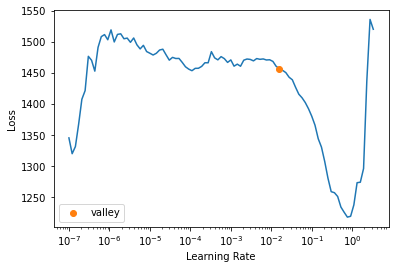

In [66]:
learn.lr_find()

Primero que nada: WTF, ¿cómo que 1400 de loss?!

¿Qué función de pérdida estamos usando? ¿Qué pasa?

In [28]:
learn.loss_func

FlattenedLoss of MSELoss()

Pues bueno, MSE = mean squared error, así que está tomando $(\text{edad_predicha} - \text{edad_real})^2$ y luego promediando. Por eso es que está la pérdida así. 


### Mean Squared Error Loss:
Está definido así: $$\text{MSE}(yp,y) = \frac{\left\lVert yp-y\right\rVert^2}{n} = \frac{\left(yp_1 - y_1\right)^2 + \dots + \left(yp_n-y_n\right)^2}{n}$$

El problema de `mse_loss` es que le preocupa equivocarse por mucho en una (y no le preocupa equivocarse por poco en todas). Entonces con los bebés es conservador y trata de ponerles 4-5 años. No vaya a ser que se equivoque.

## ¿Cómo es el modelo?

In [29]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [30]:
learn.fit_one_cycle(10,lr_max=1e-2,div=0.9,pct_start=0.75)

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(6,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

¿Cómo interpretamos la pérdida? Pues más o menos hay que sacar raiz cuadrada y ese será más o menos el error:

In [33]:
from math import sqrt
sqrt(54)

7.3484692283495345

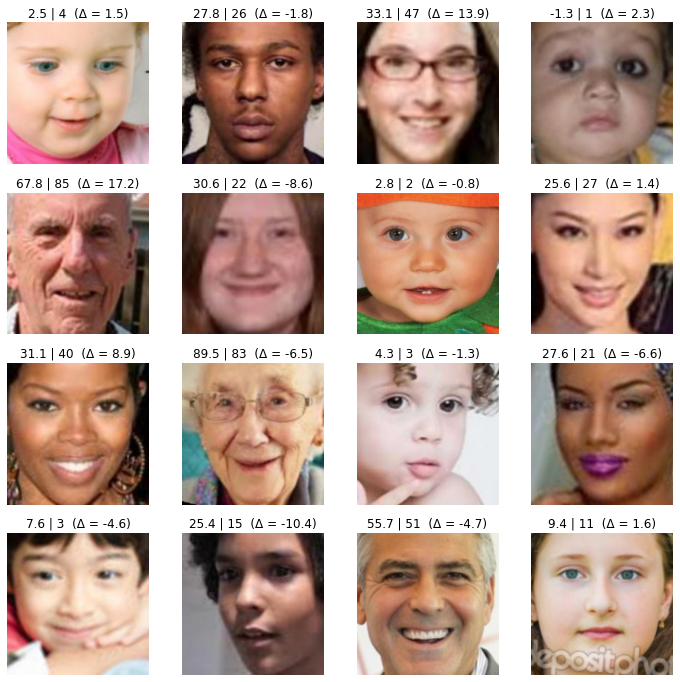

In [39]:
learn.show_results()

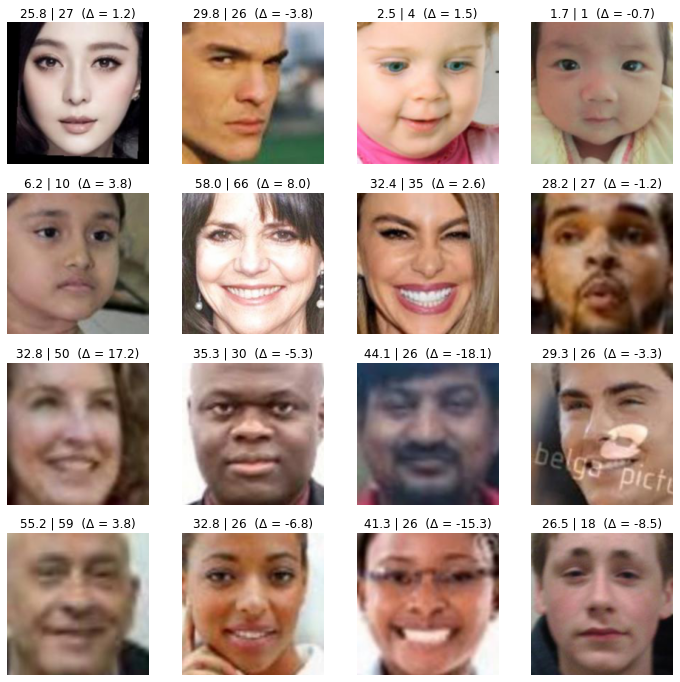

In [37]:
learn.show_results()

A ver, hay algunos problemas:

1. MSE loss está elevando al cuadrado, lo cual hace que le "de mucho miedo" equivocarse, así que todo lo "jala" hacia los 30's, que es donde está la mayoría de los datos.
2. A veces produce números negativos??! ¿Qué onda?
3. No es tan fácil interpretar el "loss"

Aún así, no podemos esperar que la red neuronal lo haga super-perfecto, obviamente, porque pues basado en la foto puedes dar un estimado, pero nadie en el mundo puede saber exactamente!

### L1 Loss:

Una mejor manera es usar `l1_loss`. 


A MSE también se le conoce como L2 loss.

El `l1_loss` está definido asi: $$L_1(a,b) = \frac{\left|a_1 - b_1\right| + \dots + \left|a_n-b_n\right|}{n}$$

In [69]:
learn = create_learner(loss_func=F.l1_loss)
#learn.loss_func

In [70]:
learn.fit_one_cycle(2,div=1)

KeyboardInterrupt: 

A ver, hubo un warning y NO está entrenando para NADA!

Bueno, aquí lo que ocurrió fue que el broadcasting nos está molestando:

In [42]:
x,y = data.one_batch()

In [43]:
y.shape

torch.Size([128])

In [44]:
learn.model(x).shape

torch.Size([128, 1])

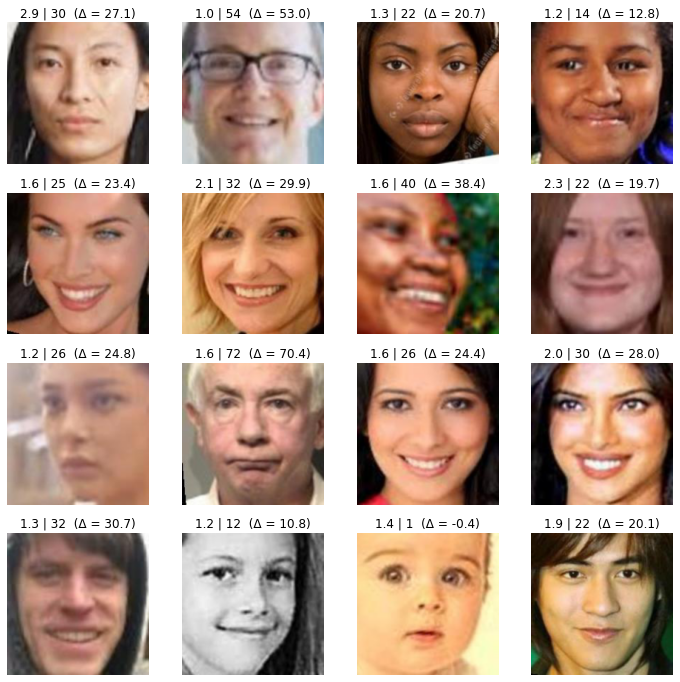

In [45]:
learn.show_results()

Podemos resolver esto de dos maneras:

1. Crear nuestra propia función de error:

In [71]:
def l1_flat(yp,y):
    yp = yp.view(-1)
    return F.l1_loss(yp,y)

In [72]:
def mse_flat(yp,y):
    yp = yp.view(-1)
    return F.mse_loss(yp,y)

In [73]:
def sqrt_mse_flat(yp,y):
    yp = yp.view(-1)
    return torch.sqrt(F.mse_loss(yp,y))

In [74]:
learn = create_learner(loss_func=l1_flat,metrics=[mse_flat,sqrt_mse_flat])

In [55]:
x = torch.randn(2,3,128,128)
model = learn.model.cpu()

In [56]:
for m in model:
    print(f"Aplicando {m}")
    x = m(x)
    print(f"\t\tyaa!! {m}")

Aplicando Normalizer()
		yaa!! {m}
Aplicando Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
		yaa!! {m}
Aplicando BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
		yaa!! {m}
Aplicando ReLU(inplace=True)
		yaa!! {m}
Aplicando MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
		yaa!! {m}
Aplicando Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

RuntimeError: running_mean should contain 1024 elements not 2048

In [75]:
learn.fit_one_cycle(10,lr_max=1e-2,div=0.9,pct_start=0.75)

In [76]:
learn.unfreeze()

In [77]:
learn.fit_one_cycle(4,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

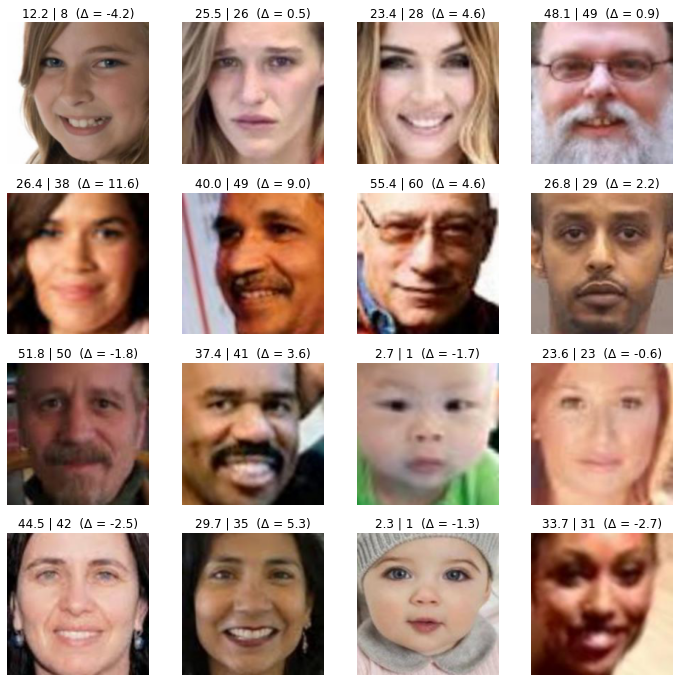

In [53]:
learn.show_results()

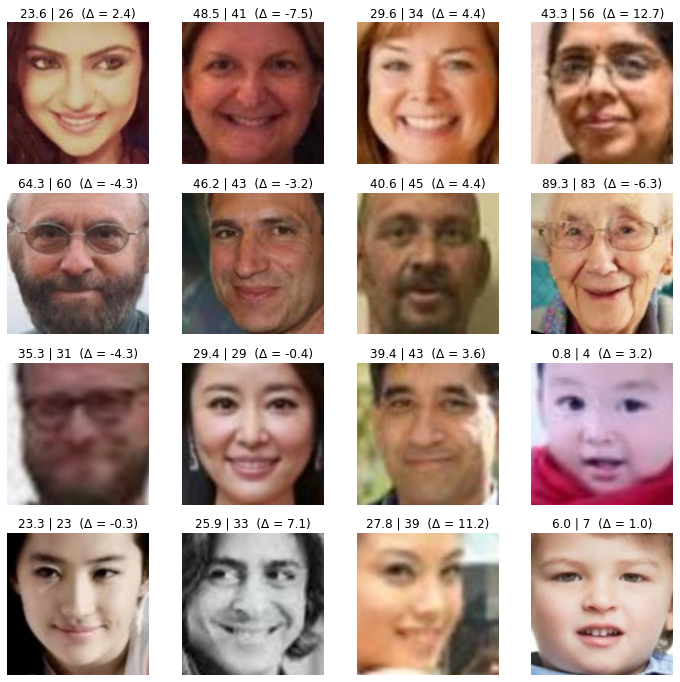

In [54]:
learn.show_results()

2. Agregamos una capa más al modelo, que simplemente le quite ese 1:

In [63]:
learn = create_learner(loss_func=F.l1_loss,metrics=F.mse_loss)

In [72]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [73]:
x,y = data.one_batch()

In [74]:
learn.model(x).shape

torch.Size([128])

In [75]:
learn.fit_one_cycle(1,1e-2,div=1)

# Números negativos??

Pues ahora la red neuronal puede predecir cualquier cosa que se le antoje. Entonces una posible mejora sería que a fuerzas la red tenga que predecir números entre 0 y 116:

In [76]:
import gc
gc.collect()

21172

In [84]:
class AgeLimiter(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.sigmoid(x)*117-0.5

Con esto predecimos siempre en el rango (-0.5,116.5)

In [85]:
def l1_plus_mse(yp, y):
    return l1_flat(yp,y) + torch.sqrt(mse_flat(yp,y))

In [86]:
learn = create_learner(loss_func=l1_plus_mse, metrics=[l1_flat, mse_flat])
learn.model = nn.Sequential(learn.model, AgeLimiter())

SuggestedLRs(valley=0.02290867641568184)

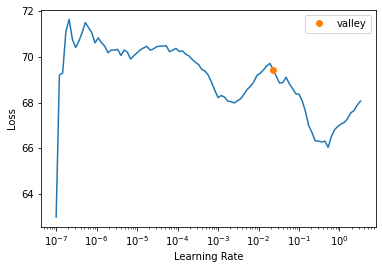

In [87]:
learn.lr_find()

In [88]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

In [89]:
learn.unfreeze()

In [90]:
learn.fit_one_cycle(1,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

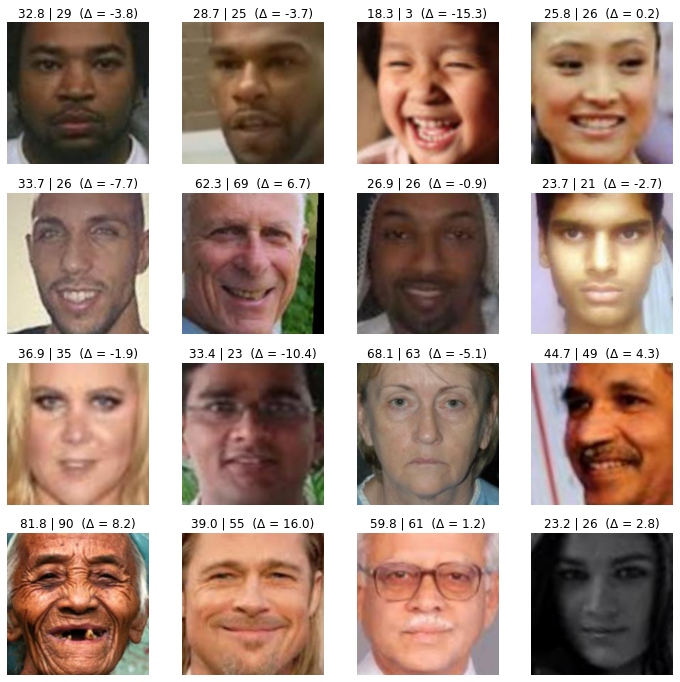

In [93]:
learn.show_results()

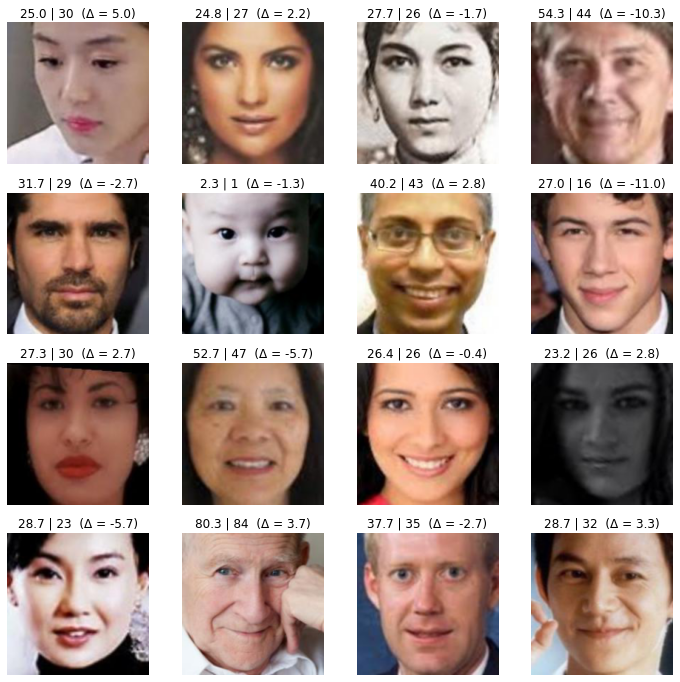

In [94]:
learn.show_results()

# La pérdida debe reflejar lo que realmente quieres

Aunque lo hace bastante bien el modelo, en realidad *no está muy bien* nuestra función de pérdida: 

Si alguien te muestra a su bebé recién nacido y dices: "¿ya tiene, qué, unos 5 años?", pues estás medio chiflado:

![bebe](./facesM/0_0_00000.jpg)

PERO, si alguien tiene 70 años y adivinas 75... pues es razonable.

![viejo](./facesM/73_0_44055.jpg)


## ¿Cómo inventamos una loss function mejor?

Aunque L1 y MSE ya funcionen bastante bien, en otras aplicaciones puede que estemos optimizando algo que no sea exactamente lo que queremos. 

Imaginemos que queremos una función de pérdida que exprese mejor lo que queremos: que la *diferencia entre valores pequeños sea grande*, pero la *diferencia entre valores grandes sea chica*. 

Para obtener esto, debemos aplicar una función cóncava *antes de hacer la diferencia*:

![función convexa](./concavefunc.png)

Entonces, por ejemplo, podríamos tomar:
$$f(a,b) = \left(\sqrt{a_1}-\sqrt{b_1}\right)^2 + \dots +  \left(\sqrt{a_n}-\sqrt{b_n}\right)^2$$

Algo muy común es tomar el logaritmo

In [ ]:
def age_loss(pred,targ):
    return F.mse_loss(torch.log(pred),torch.log(targ))

De esta manera, estaríamos pensando que equivocarse de 2 a 3 es equivalente a equivocarse de 40 a 60 (es en porcentaje). Quizás lo que queremos no es taaan extremo!

A mi me suena que equivocarme de 2 a 3 años sería más o menos equivalente a equivocarse entre 40 y 46 años. Estuve experimentando, y algo así me suena bien:

In [91]:
def age_loss(pred,targ):
    a = 0.3
    p = (1+pred)**a
    t = (1+targ)**a
    return torch.abs(p-t).mean()

In [92]:
def age_compare(a, b): 
    return age_loss(torch.tensor(float(a)), torch.tensor(float(b))).item()

In [93]:
age_compare(2,3), 
age_compare(15,18), 
age_compare(40,46), 
age_compare(60, 68), 
age_compare(90, 100)

0.12296032905578613

Nuestro modelo ya está entrenado con L1 + L2. No hay necesidad de volver a empezar, podemos sólo entrenar un poco más con la nueva función de pérdida!

In [94]:
learn.loss_func = age_loss

In [95]:
learn.fit_one_cycle(8,lr_max=slice(3e-6,1e-3),div=0.9,pct_start=0.75)

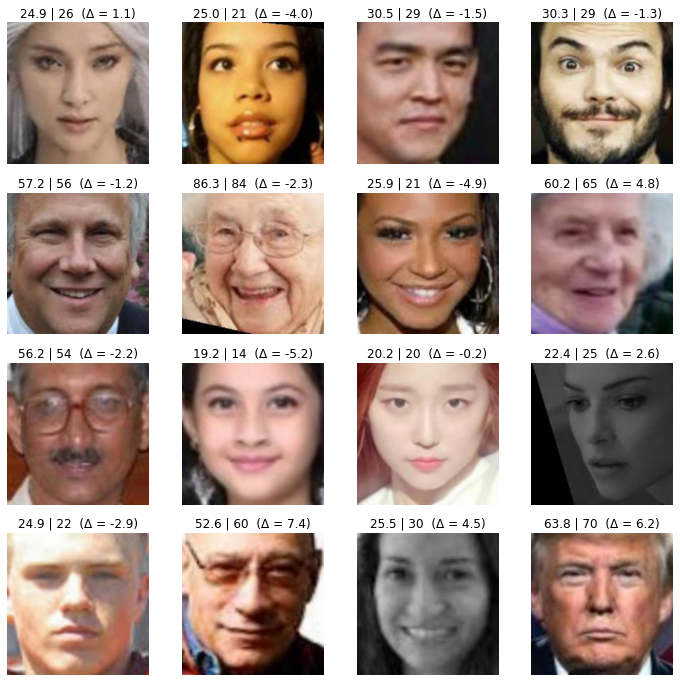

In [100]:
learn.show_results()

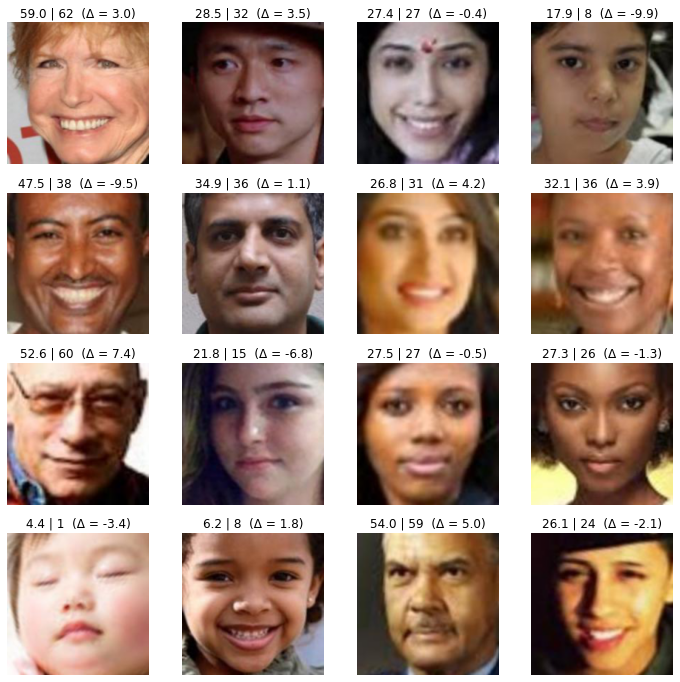

In [101]:
learn.show_results()

In [102]:
learn.save('r18-age')

Path('models/r18-age.pth')